# Introduction

In this notebook we are exploring the potential of a Rydberg platform that can operate as an analog quantum processor to solve the Unit Disk - Maximum Independent Sets (UD-MIS) optimization problem using a quantum annealing-based approximation method, and comparing it to a simple classical simulated annealing approach using the Metropolis-Hastings algorithm for this problem.

# Task 1

### Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from abstract_udmis import AbstractUDMIS

%matplotlib inline
%matplotlib notebook

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)      

In [3]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u,graph)

6


In [4]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    
    if t % 100 == 0:
        print(t, E, udmis.occupations)

0 0.4000000000000008 [ True  True  True  True False  True]
100 -1.2999999999999998 [ True  True  True  True False False]
200 -2.0 [False False  True False False  True]
300 -1.0 [False  True False False False False]
400 -3.0 [False False  True  True  True False]
500 -0.6499999999999999 [False  True  True False False False]
600 -1.65 [False False False  True  True  True]
700 -1.65 [ True False False  True  True False]
800 -1.65 [False False False  True  True  True]
900 -2.0 [False False  True False  True False]
1000 1.0500000000000003 [ True False False  True False  True]
1100 -1.65 [False False  True  True False  True]
1200 -1.65 [ True False  True False False  True]
1300 -1.65 [ True False  True  True False False]
1400 -1.2999999999999998 [False  True  True  True False  True]
1500 -2.9999999999999996 [False False  True False  True  True]
1600 -1.3000000000000003 [ True  True  True False  True False]
1700 -1.65 [ True  True False False  True False]
1800 -1.65 [False  True False  True  T

Here, we use a Python package $\texttt{networkx}$ to create a graph with nodes and edges specified by the given coordinates in $\texttt{graph}$ and the corresponding $\texttt{udmis}$.

In [5]:
import networkx as nx

def build_graph (graph, udmis):
    G = nx.Graph()# Generate a graph
    G.add_nodes_from(range(len(graph))) # Add the nodes

    edge=[]
    idx=0
    for i in range(len(graph)):
        for j in range(i):
            if udmis.find_edges()[j][i]==True:
                edge.append((i,j,1.0))
            idx+=1
    G.add_weighted_edges_from(edge) # Add the edges from edge
    return G

We add patches of unit disks with a radius of 0.5 onto all the nodes.

<IPython.core.display.Javascript object>


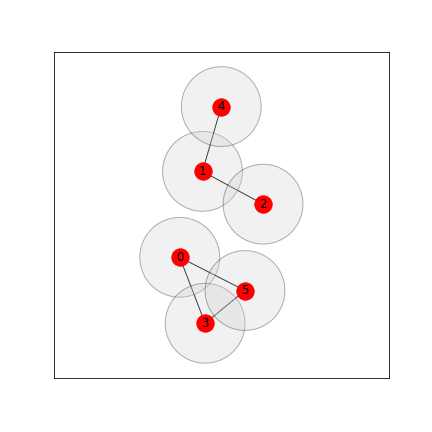

In [6]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
colors = "red" 
G = build_graph(graph,udmis)
for i,occ in enumerate(udmis.occupations):
    circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
    ax.add_patch(circle)
nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)

## Comparisons between three different cooling schedules:  geometric, Lundy and Mees, and linear.

In Task 1, we refer to Peprah, et al.'s work [1](https://doi.org/10.4236/am.2017.88090) on the comparison of cooling schedules. We focus on three different cooling schedules:

1. Geometric cooling: $T_{t+1}=\alpha^t T_t$ where $\alpha= (\frac{T_f}{T_i})^{1/N} $

2. Lundy and Mees (L & M)

3. Linear (or arithmetic) cooling: $ T_{t+1}=T_t - \gamma$ where $\gamma= \frac{T_i-T_f}{N}$

For geometric cooling schedule, the annealing is done after 3573 iterations. The L & M cooling only takes less than 500 iterations to reach a stable ground state. Linear cooling does not show an apparent convergence even after 50000 iterations.

By comparing geometric, L& M, and linear cooling schedules, we conclude that L & M cooling schedule can lead to a solution to the UD-MIS problem much faster (less than 500 steps).

Note that the given graph has a degeneracy for the lower triangle (nodes 0, 3, and 5), the solution of the UD-MIS problem can be nodes 2, 4, and either of 0, 3, or 5.

Reference: A.K.,  Appiah,  S.K.  and  Amponsah,  S.K.  (2017)  An Optimal  Cooling  Schedule  Using  a  Simulated  Annealing  Based  Approach.  Applied Mathematics, 8, 1195-1210.


### 1.  Default cooling schedule: 

geometric cooling $ T_{t+1}=\alpha^t T_t$ where $\alpha= (\frac{T_f}{T_i})^{1/N} $


<IPython.core.display.Javascript object>


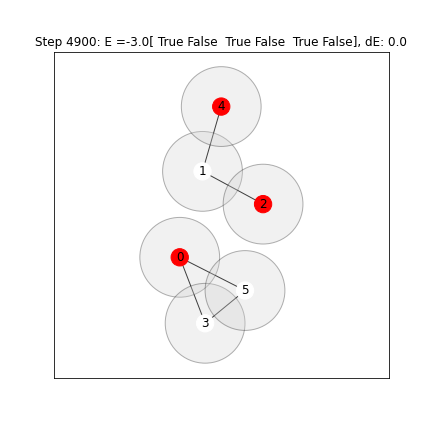

C:\Users\Aida\Anaconda3\envs\ForeQast_1\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Aida\Anaconda3\envs\ForeQast_1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The annealing is done at time = 3573


In [7]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
plt.ion()
fig.show()
fig.canvas.draw()

E_prev=0
dE=np.empty(N) # dE/dt for checking whether the annealing is stabilized.

t_reach=0
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    G=build_graph(graph,udmis)
    colors = ["red" if occ else "white" for occ in udmis.occupations]
    dE[t]=E-E_prev
    if t % 100 == 0:
        ax.clear()
        
        for i,occ in enumerate(udmis.occupations):
            circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
            ax.add_patch(circle)
        nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)
        plt.title("Step "+ str(t)+": E ="+str(np.round(E,2))+str(udmis.occupations)+", dE: "+str(np.round(dE[t],3)))
        fig.canvas.draw()
    E_prev=E
    if np.mean(abs(dE[t-100:t]))<1e-4 and t_reach ==0: 
    # If dE/dt is nearly zero over an interval of t=100, we say that has reached to the ground state.
        t_reach=t-100

print("The annealing is done at time = "+str(t_reach))

#### Here we plot the energy difference for each step.

<IPython.core.display.Javascript object>


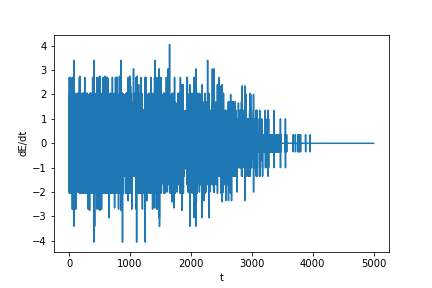

In [8]:
plt.figure()
plt.plot(np.arange(N),dE)
plt.xlabel('t')
plt.ylabel('dE/dt')
#plt.arrow(x=t_reach,y=3, dx=0, dy=-2, width=1,head_width=100,head_length=0.5,length_includes_head=True, color='red')
#plt.text(x= t_reach, y= 3.5,s= "t = "+str(t_reach))
plt.show()

#### Here is the plot of the cooling schedule

<IPython.core.display.Javascript object>


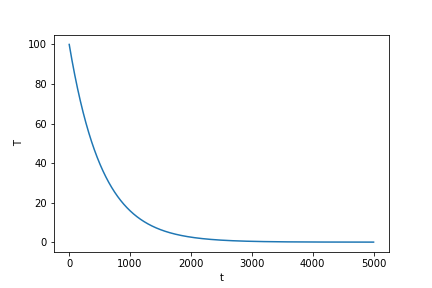

In [9]:
plt.figure()
plt.plot(np.arange(N+1),T)
plt.xlabel('t')
plt.ylabel('T')
plt.show()

### 2.  Lundy and Mees (L & M)  cooling: 
$ T_{t+1}=\frac{T_t}{1+\beta T_t}$ where $\beta= (\frac{T_i-T_f}{NT_fT_i})$

<IPython.core.display.Javascript object>


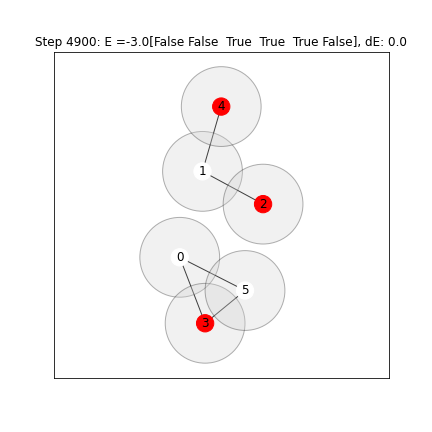

The annealing is done at time = 463


In [11]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01


fig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
plt.ion()
fig.show()
fig.canvas.draw()

E_prev=0
dE=np.empty(N) # dE/dt for checking whether the annealing is stabilized.

t_reach=0
T=np.empty(N+1)

temp=T_i

beta=(T_i-T_f)/(N*T_i*T_f)
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    T[t]=temp
    E = udmis.mc_step(T=temp)
    G=build_graph(graph,udmis)
    
    temp=temp/(1+beta*temp)
    colors = ["red" if occ else "white" for occ in udmis.occupations]
    dE[t]=E-E_prev
    if t % 100 == 0:
        ax.clear()
        
        for i,occ in enumerate(udmis.occupations):
            circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
            ax.add_patch(circle)
        nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)
        plt.title("Step "+ str(t)+": E ="+str(np.round(E,2))+str(udmis.occupations)+", dE: "+str(np.round(dE[t],3)))
        fig.canvas.draw()
    E_prev=E
    if np.mean(abs(dE[t-100:t]))<1e-4 and t_reach ==0: 
    # If dE/dt is nearly zero over an interval of t=100, we say that has reached to the ground state.
        t_reach=t-100

print("The annealing is done at time = "+str(t_reach))

<IPython.core.display.Javascript object>


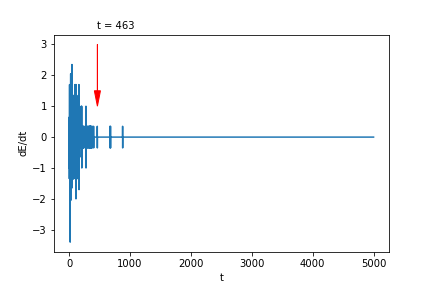

In [12]:
## Plot the energy difference for each step.

plt.figure()
plt.plot(np.arange(N),dE)
plt.xlabel('t')
plt.ylabel('dE/dt')
plt.arrow(x=t_reach,y=3, dx=0, dy=-2, width=1,head_width=100,head_length=0.5,length_includes_head=True, color='red')
plt.text(x= t_reach, y= 3.5,s= "t = "+str(t_reach))
plt.show()

<IPython.core.display.Javascript object>


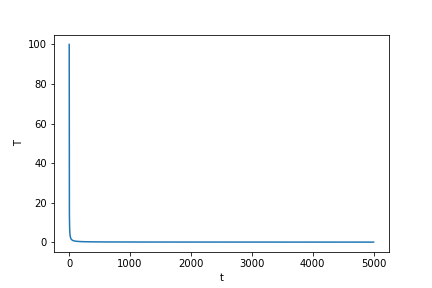

In [13]:
## Plot the cooling schedule.

plt.figure()
plt.plot(np.arange(N+1),T)
plt.xlabel('t')
plt.ylabel('T')
plt.show()

L & M cooling only takes less than 500 iterations to reach a stable ground state.

### 3. Linear (or arithmetic) cooling: 

$ T_{t+1}=T_t - \gamma$ where $\gamma= \frac{T_i-T_f}{N}$

<IPython.core.display.Javascript object>


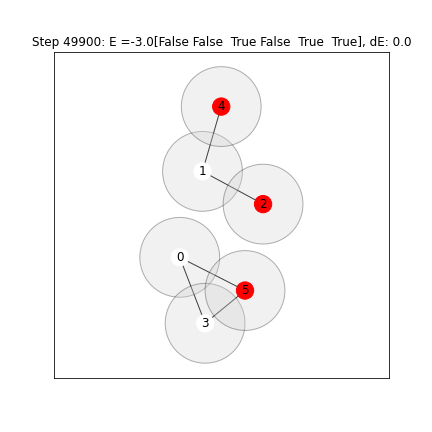

C:\Users\Aida\Anaconda3\envs\ForeQast_1\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Aida\Anaconda3\envs\ForeQast_1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The annealing is done at time = 0


In [17]:
N = 50000
t = np.arange(N+1)
T_i = 100
T_f = 0.01


fig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
plt.ion()
fig.show()
fig.canvas.draw()

E_prev=0
dE=np.empty(N) # dE/dt for checking whether the annealing is stabilized.

t_reach=0
T=np.empty(N+1)

temp=T_i

gamma=(T_i-T_f)/N
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    T[t]=temp
    E = udmis.mc_step(T=temp)
    G=build_graph(graph,udmis)
    
    temp=temp-gamma
    colors = ["red" if occ else "white" for occ in udmis.occupations]
    dE[t]=E-E_prev
    if t % 100 == 0:
        ax.clear()
        
        for i,occ in enumerate(udmis.occupations):
            circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
            ax.add_patch(circle)
        nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)
        plt.title("Step "+ str(t)+": E ="+str(np.round(E,2))+str(udmis.occupations)+", dE: "+str(np.round(dE[t],3)))
        fig.canvas.draw()
    E_prev=E
    if np.mean(abs(dE[t-100:t]))<1e-4 and t_reach ==0: 
    # If dE/dt is nearly zero over an interval of t=100, we say that has reached to the ground state.
        t_reach=t-100

print("The annealing is done at time = "+str(t_reach))

<IPython.core.display.Javascript object>


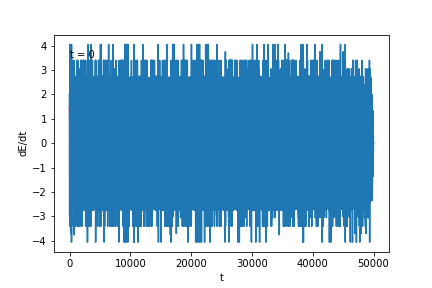

In [16]:
## Plot the energy difference for each step.

plt.figure()
plt.plot(np.arange(N),dE)
plt.xlabel('t')
plt.ylabel('dE/dt')
plt.arrow(x=t_reach,y=3, dx=0, dy=-2, width=1,head_width=100,head_length=0.5,length_includes_head=True, color='red')
plt.text(x= t_reach, y= 3.5,s= "t = "+str(t_reach))
plt.show()

<IPython.core.display.Javascript object>


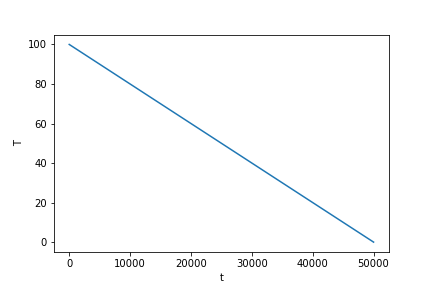

In [18]:
## Plot the cooling schedule.

plt.figure()
plt.plot(np.arange(N+1),T)
plt.xlabel('t')
plt.ylabel('T')
plt.show()

Linear cooling does not show an apparent convergence even after 50000 iterations.

# Task 2

Here we are addressing the UDMIS problem quantum-ly where we get a solution to it from the julia notebook (see quantum_annealing.jl) in the form of the most probable bitstring that we get from measuring the wavefunction. Here we map this solution to the same graph to compare to the solution of task 1 where we adressed the problem classically. Make sure to run the sampling code in the julia notebook for a few thousands shots and choose the most frequent outcome as your desired ground state. By repeating the sampling we observe that there are one or a few bitstrings that come with the maximal probability, we expect that to be the ground state. 
The Rydberg atom lattice needs to have the same number of atoms NA as the number of vertices NV in the graph we are trying to find the US-MIS solution for. Each possible state of the system is represented as a bitstring of NA dimension and each bit can be either 0 (atom in the ground state) or 1 (atom in the excited Rydberg state). A 0 is equivalent to the boolean 'false' of task 1 (the vertices ij do not overlap) and a one would correspond to the boolean 'true' (vertices ij do overlap). The interaction between Rydberg atoms is significantly higher for excited atoms, in the ground state neutral atoms hardly interact. 

We have three potential solution for the ground state for bitstrings 21 (101010), 28 (001110), and 52 (001011). The desired solution that gives the same answer as in question 1 is the string 001011 and is shown below.

We upload the same graph as for task 1:

In [25]:
graph = [(0.3461717838632017, 1.4984640297338632), (0.6316400411846113, 2.5754677320579895), (1.3906262250927481, 2.164978861396621), (0.66436005100802, 0.6717919819739032), (0.8663329771713457, 3.3876341010035995), (1.1643107343501296, 1.0823066243402013)]


df = pd.read_csv ('qUDMIS.csv')
print(type(df),len(df))
arr = df.to_numpy()
print(arr)
qsol=[]
for i in range(0,6):
    booleans=bool(arr[i])
    qsol.append(booleans)
print(reversed(qsol))

<class 'pandas.core.frame.DataFrame'> 6
[[False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]]


<IPython.core.display.Javascript object>


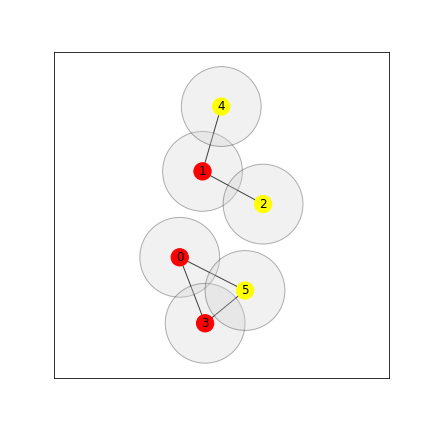

In [26]:
qfig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
colors = ["red" if occ else "yellow" for occ in reversed(qsol)]
G = build_graph(graph,udmis)
for i,occ in enumerate(reversed(qsol)):
    circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
    ax.add_patch(circle)
nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)

# Task 3

1. This falls into the UD-MIS problem since we can map the nodes of the graph as potential cell tower locations. An n-bit string corresponding to the length of potential cell tower locations: wherein a 1 corresponds to having a cell tower at the potential location, and a 0 corresponds to not having the cell tower at the potential location. Cell tower signals correspond to the unit disks, and our goal is to avoid any overlap of those disks. We are trying to maximize our cell tower coverage provided by the Hamming weight of the bit string, which is the same goal as UD-MIS.
2. Below we have used the classical optimization method from task 1 and the quantum anneling from task 2 to solve the Gotham City's problem.
3. UD-MIS is not an appropriate solution to this problem for any telecom. While telecoms try to avoid overlap, their formulation is actually far more complex than simply UD-MIS. The problem with using UD-MIS is that Bruce is creating huge areas of no coverage for high population density areas. Bruce should certainly pay for more cell towers to ensure adequate, even coverage across the entire city. T-Mobile will likely compete on "fewer dropped calls" than Batman Mobile, and therefore he would likely have to maximize the areal coverage while minimizing cell tower installations along this multi-objective Pareto front.

**Classical simulated annealing:**

12


<IPython.core.display.Javascript object>


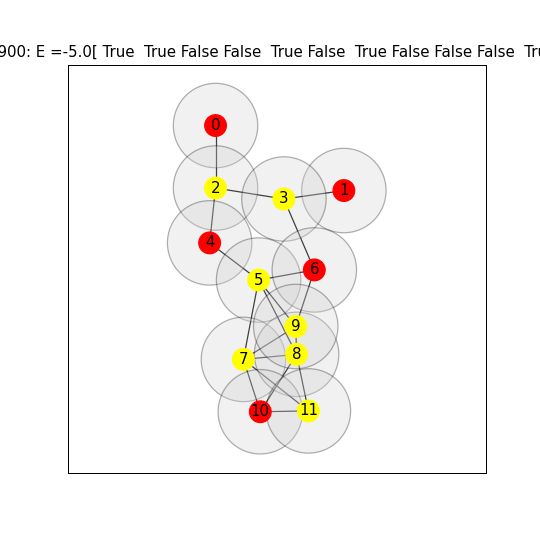

In [14]:
locations = [(1.19, 4.25), (2.71, 3.48),(1.19, 3.51),(2, 3.38),(1.12, 2.86),(1.70, 2.42),(2.36, 2.54),(1.52, 1.48),(2.15, 1.54),(2.14, 1.87),(1.72, 0.86),(2.29, 0.87)]
udmis = UDMIS(u, locations)


N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(frame_on=True)
ax.axis('equal')
plt.ion()
fig.show()
fig.canvas.draw()

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    G=build_graph(locations,udmis)
    colors = ["red" if occ else "yellow" for occ in udmis.occupations]

    if t % 100 == 0:
        ax.clear()
        
        for i,occ in enumerate(udmis.occupations):
            circle = Circle(xy=graph[i], radius = 0.5,alpha=0.3,facecolor='lightgray',edgecolor='black',linestyle='-',linewidth=1)
            ax.add_patch(circle)
        nx.draw_networkx(G, node_color=colors, alpha=1, pos=graph, with_labels=True)
        plt.title("Step "+ str(t)+": E ="+str(np.round(E,2))+str(udmis.occupations))
        fig.canvas.draw()